# **Anomaly Detection Algorithm using Gaussian Mixture Model**

This code is about credit card fraud detection. The dataset contains 28 key features.

In [190]:
pip install wget

In [191]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar (2).gz'

In [192]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [194]:
print(df.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [196]:
dataset_data=df.iloc[:,:-1]
target_data=df.iloc[:,-1]

We will split the dataset into a training (70%), validation (15%) and testing set (15%).

In [197]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset_data, target_data, test_size=0.15, random_state=0)

X_train, X_val, y_train, y_val, = train_test_split(X_train, y_train, test_size=(15/85), random_state=0) #we need to account for the fact that now X_train contains 85% of the dataset and not 100% of it

Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

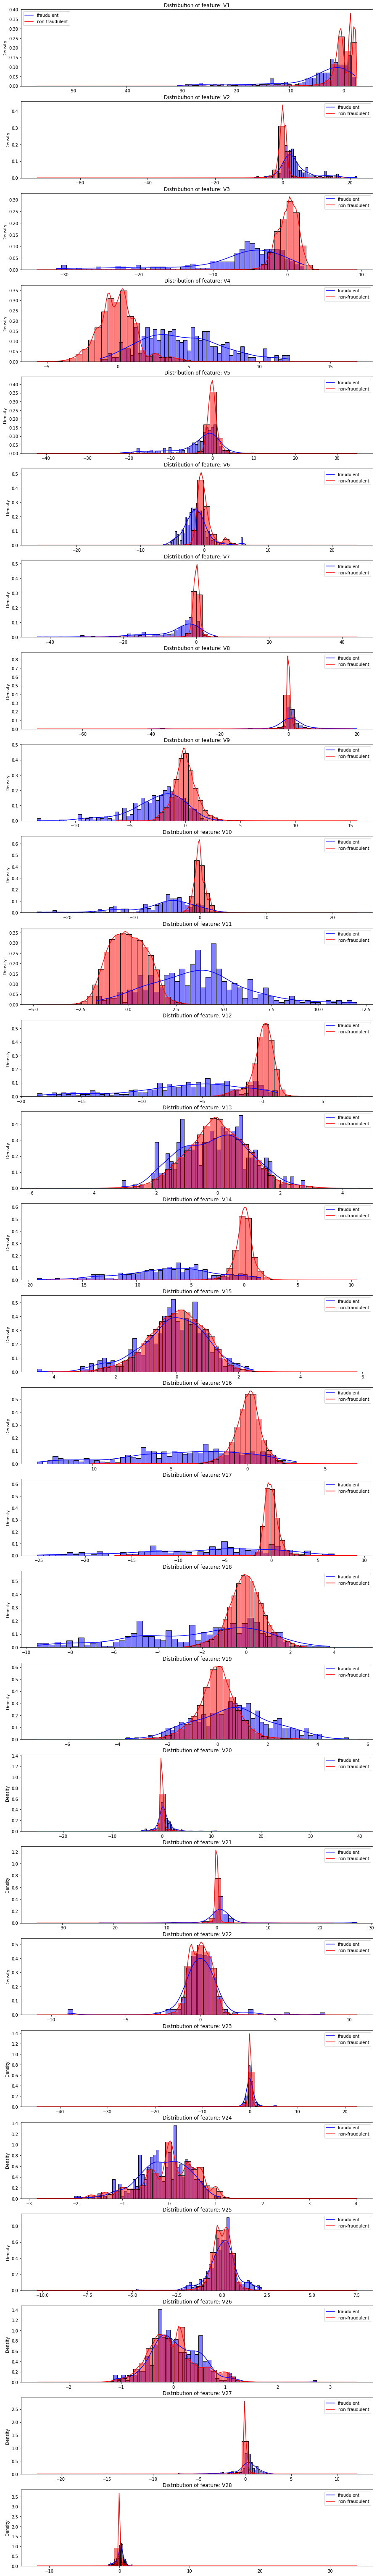

In [198]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

These graphs can provide meaningful information about anomaly detection using a gaussian model by:

- Seeing how the data is distributed, when we have fraudulent or non-fraudulent labels, and whether we should fit them with a gaussian distribution or GMM.
- Visually eliminating the usage of some features.

## Single Feature, Single Gaussian Distribution

For exploration purposes, we will fit a single Gaussian distribution on only a single feature at a time, and find the three features that allow us to best distinguish fraudulent transactions based on the AUC of the validation set.

In [199]:
X_train_array=X_train.copy()
X_train_array=np.array(X_train_array)

X_val_array=X_val.copy()
X_val_array=np.array(X_val_array)

y_train_array=y_train.copy()
y_train_array=np.array(y_train_array)

y_val_array=y_val.copy()
y_val_array=np.array(y_val_array)

In [200]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[:,1].reshape(-1,1))

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=1, n_init=1, precisions_init=None,
                random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [201]:
p_gm1 = gm.score_samples(X_train_array[:,1].reshape(-1,1))
p_gm2 = gm.score_samples(X_val_array[:,1].reshape(-1,1))

from sklearn.metrics import roc_auc_score

print("The AUC for the full training set is:", roc_auc_score(y_train_array, 1-p_gm1))
print("The AUC for the full validation set is:", roc_auc_score(y_val_array, 1-p_gm2))

The AUC for the full training set is: 0.704715046152276
The AUC for the full validation set is: 0.731833177423688


In [202]:
AUC1=[]
AUC2=[]
for i in range(1,len(X_train.columns)-1):
  gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
  gm.fit(X_train_array[:,i].reshape(-1,1))
  p_gm1 = gm.score_samples(X_train_array[:,i].reshape(-1,1))
  p_gm2 = gm.score_samples(X_val_array[:,i].reshape(-1,1))
  AUC1.append(roc_auc_score(y_train_array, 1-p_gm1))
  AUC2.append(roc_auc_score(y_val_array, 1-p_gm2))

In [203]:
AUC1=np.array(AUC1).reshape(1,-1)
AUC2=np.array(AUC2).reshape(1,-1)

AUC=np.concatenate((AUC1,AUC2),axis=0)

AUC_scores=pd.DataFrame(AUC,index=['Training', 'Validation'],columns=X_train.columns[1:-1])
print(AUC_scores)

                  V1        V2        V3        V4        V5        V6  ...  \
Training    0.704715  0.848104  0.880042  0.894416  0.760907  0.734653  ...   
Validation  0.731833  0.837961  0.832369  0.871487  0.816581  0.721507  ...   

                 V23       V24       V25       V26       V27       V28  
Training    0.691576  0.479669  0.578081  0.498072  0.828401  0.821009  
Validation  0.723037  0.455708  0.555059  0.547121  0.835234  0.755684  

[2 rows x 28 columns]


In [204]:
AUC_val_sorted=AUC2.copy()
AUC_val_sorted=np.flip(np.sort(AUC_val_sorted))[0]
max_AUC_values=AUC_val_sorted[0:3]

best_features=[]
best_features.append(X_train.columns[np.where(AUC2==max_AUC_values[0])[1][0]+1])
best_features.append(X_train.columns[np.where(AUC2==max_AUC_values[1])[1][0]+1])
best_features.append(X_train.columns[np.where(AUC2==max_AUC_values[2])[1][0]+1])
print("The maximum 3 values are:", max_AUC_values[0], "for", X_train.columns[np.where(AUC2==max_AUC_values[0])[1][0]+1], ", and", max_AUC_values[1], "for", X_train.columns[np.where(AUC2==max_AUC_values[1])[1][0]+1], ", and", max_AUC_values[2], "for", X_train.columns[np.where(AUC2==max_AUC_values[2])[1][0]+1])

The maximum 3 values are: 0.9552970953177244 for V14 , and 0.9280062095946573 for V12 , and 0.9257025422574674 for V17


We will make a prediction based on a model's scores: If the score_samples is lower than a threshold, we consider that transaction as fraud. 

The optimal threshold will maximize the F1 Score of the validation set for each of those 3 features separately.

The best threshold is -12.199999999999998 for vector 12


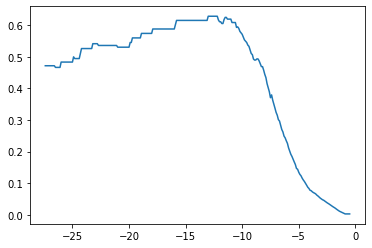

In [205]:
#V12

from sklearn.metrics import f1_score

gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[:,12].reshape(-1,1))
p_gm2 = gm.score_samples(X_val_array[:,12].reshape(-1,1)) #p_gm2 are negative values, so our threshold should be negative

def threshold_find(y_val, p):
  f1score=[]
  k=[]
  for i in np.arange(0.5,200,0.5): #I chose 200 because I initially set it up to be 350, but the thresholds that gave the max F1 scores never reached 350, so I reduced this interval to decrease the computations.
    threshold=-i
    f1score.append(f1_score(y_val, p<=threshold))
    k.append(threshold)

  k=np.abs(k[np.argmax(f1score)])

  f1score2=[]
  k2=[]
  for i in np.arange(max(k-15,0.5),k+15,0.1): #This loop will make the selection of the best threshold even more accurate than before.
    threshold=-i
    f1score2.append(f1_score(y_val, p<=threshold))
    k2.append(threshold)

  f1score2=np.array(f1score2)
  maximum=k2[np.argmax(f1score2)]
  f1score_max=np.max(f1score2)
  plt.plot(-1*np.flip(np.arange(max(k-15,0.5),k+15,0.1)), np.flip(f1score2))
  return maximum, f1score_max

maximum_1,f1score_max1=threshold_find(y_val, p_gm2)
print("The best threshold is", maximum_1, "for vector 12")

The best threshold is -23.09999999999994 for vector 14


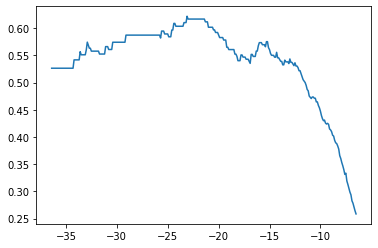

In [206]:
#V14

gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[:,14].reshape(-1,1))
p_gm2 = gm.score_samples(X_val_array[:,14].reshape(-1,1))

maximum_2,f1score_max2=threshold_find(y_val, p_gm2)
print("The best threshold is", maximum_2, "for vector 14")

The best threshold is -21.89999999999995 for vector 17


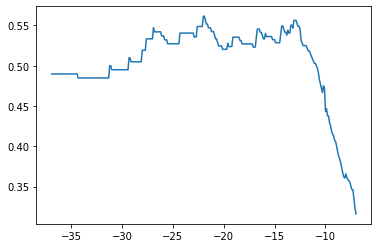

In [207]:
#V17
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[:,17].reshape(-1,1))
p_gm2 = gm.score_samples(X_val_array[:,17].reshape(-1,1))
maximum_3,f1score_max3=threshold_find(y_val, p_gm2)
print("The best threshold is", maximum_3, "for vector 17")

In [208]:
f1score=np.array([f1score_max1,f1score_max2,f1score_max3]).reshape(1,-1)
features_f=['V12','V14','V17']
f1score=pd.DataFrame(f1score, index=['F1 score'],columns=features_f)
print(f1score)

               V12       V14       V17
F1 score  0.628571  0.621849  0.561404


Next, we will fit the Guassian model only on the non-fraudulent transactions instead of all the transactions to check if the model will perform better.

The best threshold is -13.499999999999996 for vector 12


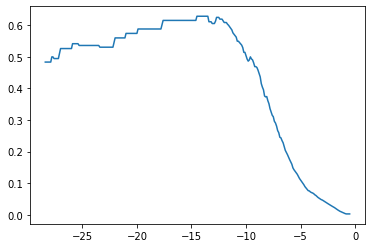

In [209]:
#V12
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[np.where(y_train_array==0),12][0].reshape(-1,1))
p_gm2 = gm.score_samples(X_val_array[:,12].reshape(-1,1))

maximum_4, f1score2_max1=threshold_find(y_val, p_gm2)
print("The best threshold is", maximum_4, "for vector 12")

 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**

The best threshold is -26.09999999999994 for vector 14


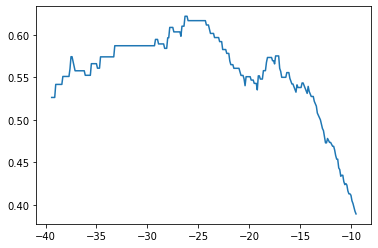

In [210]:
#V14
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[np.where(y_train_array==0),14][0].reshape(-1,1))
p_gm2 = gm.score_samples(X_val_array[:,14].reshape(-1,1))

maximum_5,f1score2_max2=threshold_find(y_val, p_gm2)
print("The best threshold is", maximum_5, "for vector 14")

The best threshold is -27.799999999999947 for vector 17


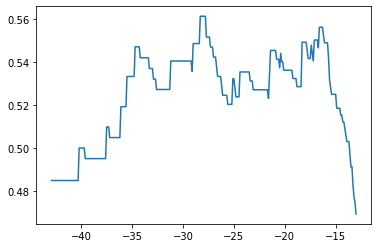

In [211]:
#V17
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[np.where(y_train_array==0),17][0].reshape(-1,1))
p_gm2 = gm.score_samples(X_val_array[:,17].reshape(-1,1))

maximum_6,f1score2_max3=threshold_find(y_val, p_gm2)
print("The best threshold is", maximum_6, "for vector 17")

In [212]:
AUC1_2=[]
AUC2_2=[]

bestfeatures=[12, 14, 17]
for i in bestfeatures:
  gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
  gm.fit(X_train_array[np.where(y_train_array==0),i][0].reshape(-1,1))
  p_gm1 = gm.score_samples(X_train_array[:,i].reshape(-1,1))
  p_gm2 = gm.score_samples(X_val_array[:,i].reshape(-1,1))
  AUC1_2.append(roc_auc_score(y_train_array, 1-p_gm1))
  AUC2_2.append(roc_auc_score(y_val_array, 1-p_gm2))

AUC1_2=np.array(AUC1_2).reshape(1,-1)
AUC2_2=np.array(AUC2_2).reshape(1,-1)

AUC_2=np.concatenate((AUC1_2,AUC2_2),axis=0)

AUC_2_scores=pd.DataFrame(AUC_2,index=['Training', 'Validation'],columns=['V12', 'V14', 'V17'])
print("AUC Scores by fitting both fraudulent and non-fraudulent data:")
print(AUC_2_scores)
print()
AUC_scores_bestfeatures=AUC_scores.iloc[:,[11,13,16]]
print("AUC Scores by only fitting non-fraudulent data:")
print(AUC_scores_bestfeatures)
print()


f1score2=np.array([f1score_max1,f1score_max2,f1score_max3]).reshape(1,-1)
features_f=['V12','V14','V17']
f1score2=pd.DataFrame(f1score2, index=['F1 score'],columns=features_f)

print("F1 Scores by fitting both fraudulent and non-fraudulent data:")
print(f1score)
print()

print("F1 Scores by only fitting non-fraudulent data:")
print(f1score2)
print()

maximum_2a=np.array([maximum_1,maximum_2,maximum_3]).reshape(1,-1)
maximum_2b=np.array([maximum_4,maximum_5,maximum_6]).reshape(1,-1)
maximum_21=pd.DataFrame(maximum_2a, index=['Threshold'],columns=features_f)
print("Thresholds by fitting both fraudulent and non-fraudulent data:")
print(maximum_21)
print()

print("Thresholds by only fitting non-fraudulent data:")
maximum_22=pd.DataFrame(maximum_2b, index=['Threshold'],columns=features_f)
print(maximum_22)
print()

AUC Scores by fitting both fraudulent and non-fraudulent data:
                V12       V14       V17
Training    0.91361  0.949827  0.926960
Validation  0.92837  0.956061  0.926476

AUC Scores by only fitting non-fraudulent data:
                 V12       V14       V17
Training    0.912838  0.949740  0.927538
Validation  0.928006  0.955297  0.925703

F1 Scores by fitting both fraudulent and non-fraudulent data:
               V12       V14       V17
F1 score  0.628571  0.621849  0.561404

F1 Scores by only fitting non-fraudulent data:
               V12       V14       V17
F1 score  0.628571  0.621849  0.561404

Thresholds by fitting both fraudulent and non-fraudulent data:
            V12   V14   V17
Threshold -12.2 -23.1 -21.9

Thresholds by only fitting non-fraudulent data:
            V12   V14   V17
Threshold -13.5 -26.1 -27.8



The results for the AUC are very similar when we fit the model on all the dataset versus only the fraudulent data point, but the values when we only fitted the non fraudulent data was smaller than the one when we fitted all the data. The F1 scores are the same although the threshold is different between the two cases (higher for second case).

The AUC scores being different is expected because when we are only fitting on the non-fraudulent data, we are not considering the fraudulent ones and so our model is not trained on them (lower true positive rate because we are predicting the fraudulent transactions as non fraudulent). However, since the data is imbalanced, meaning the number of data points that represent non fraudulent transactions is larger than that of the fraudulent transactions, it is expected that we are not getting much of a difference between the two.

As for the F1 scores, when we are only fitting on the non-fraudulent transactions, we expect the F1 score to increase. However, we were able to change (in this case increase) our thresholds in a way that maintains the same values of F1 scores. This could be due to the fact that now the distribution of the true positive and true negative rates have changed, so we need to account for this by changing our thresholds.

## Multiple Features, Single Gaussian Distribution

In this section, I will select two pairs of features and visually decide a number of Gaussian components to fit the data by focusing on the valid transactions.

I will follow similar steps as previously to find the threshold that maximizes the F1 score on the validation set.

**FEATURES 1 AND 2**

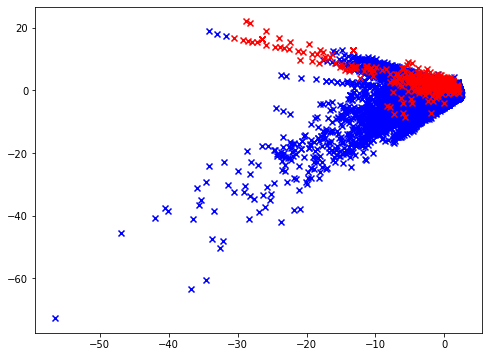

In [213]:
#plt.figure(figsize=(8,6))
#plt.scatter (X_train_array[:,1],X_train_array[:,2], marker='x', c=y_train, cmap='vlag')

plt.figure(figsize=(8,6)) #I used this because it helps show more where the fraudulent data is since they are intertwined with the non-fraudulent data.
plt.scatter (X_train_array[np.where(y_train==0),1],X_train_array[np.where(y_train==0),2], marker='x', c='blue')
plt.scatter (X_train_array[np.where(y_train==1),1],X_train_array[np.where(y_train==1),2], marker='x', c='red')

Since most valid data is concentrated in one blob, we need a single component Gaussian distribution but this might not be helpful to distinguish between the non-fraudulent and fraudulent data because some of the latter are imbedded within the former.

AUC for training: 0.8524751552392811
AUC for validation: 0.8540808512443376
The best threshold is -43.90000000000021 for V1 and V2 for an F1 score of  0.11920529801324503


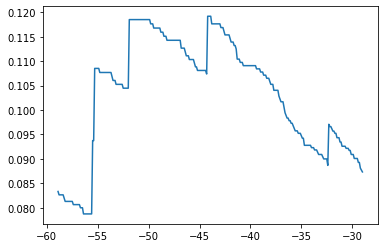

In [214]:
#V1 and V2

gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[:,[1,2]].reshape(-1,2))
p_gm = gm.score_samples(X_train_array[:,[1,2]].reshape(-1,2))
AUC=roc_auc_score(y_train_array, 1-p_gm)
p_gm2 = gm.score_samples(X_val_array[:,[1,2]].reshape(-1,2))
AUC2=roc_auc_score(y_val_array, 1-p_gm2)
print ("AUC for training:", AUC)
print ("AUC for validation:", AUC2)
maximum,f1score3_max1=threshold_find(y_val, p_gm2)
print("The best threshold is", maximum,"for V1 and V2 for an F1 score of ", f1score3_max1)

Note that having a number of components=2 would increase our AUC and F1 score but visually, this is not accurate.

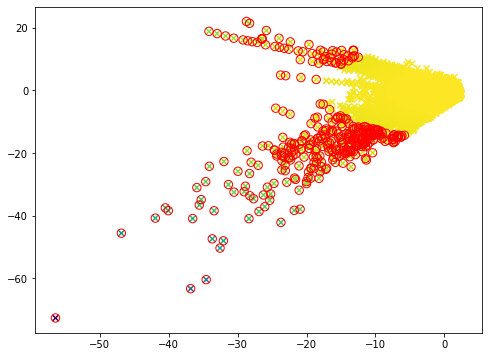

In [215]:
plt.figure(figsize=(8,6))
plt.scatter (X_train_array[:,1],X_train_array[:,2], c= p_gm, marker='x', cmap='viridis')
outliers = np.nonzero(p_gm<=maximum)[0]
plt.scatter(X_train_array[outliers,1],X_train_array[outliers,2],marker="o",facecolor="none",edgecolor="r",s=70);

**FEATURES 17 AND 20**

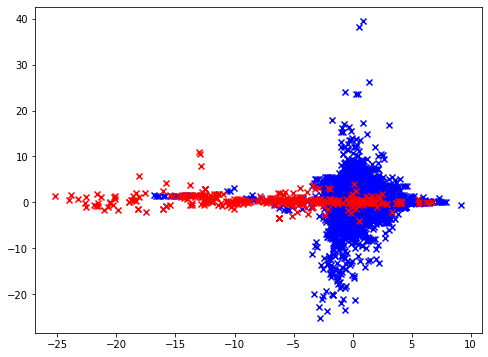

In [219]:
#plt.figure(figsize=(8,6))
#plt.scatter (X_train_array[:,17],X_train_array[:,20], marker='x', c=y_train, cmap='vlag')

plt.figure(figsize=(8,6))
plt.scatter (X_train_array[np.where(y_train==0),17],X_train_array[np.where(y_train==0),20], marker='x', c='blue')
plt.scatter (X_train_array[np.where(y_train==1),17],X_train_array[np.where(y_train==1),20], marker='x', c='red')

Like the previous cases, most valid data is concentrated in one blob, we need a single component Gaussian distribution.

0.9425880307345432
0.9463935010608553
The best threshold is -67.50000000000021 for V17 and V20 for an F1 score of  0.3442622950819672


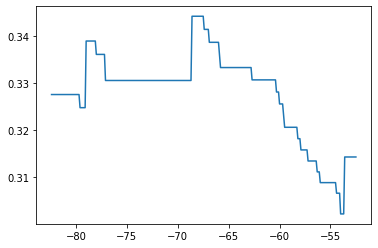

In [220]:
gm = GaussianMixture(n_components =1, covariance_type = 'full', random_state=0)
gm.fit(X_train_array[:,[17,20]].reshape(-1,2))

p_gm = gm.score_samples(X_train_array[:,[17,20]].reshape(-1,2))
AUC=roc_auc_score(y_train_array, 1-p_gm)
p_gm2 = gm.score_samples(X_val_array[:,[17,20]].reshape(-1,2))
AUC2=roc_auc_score(y_val_array, 1-p_gm2)
print (AUC)
print (AUC2)

maximum,f1score3_max3=threshold_find(y_val, p_gm2)
print("The best threshold is", maximum,"for V17 and V20 for an F1 score of ", f1score3_max3)

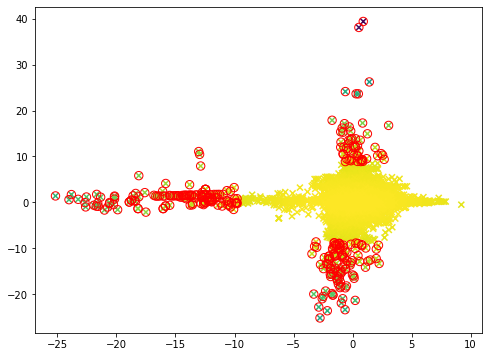

In [221]:
plt.figure(figsize=(8,6))
plt.scatter (X_train_array[:,17],X_train_array[:,20], c= p_gm, marker='x', cmap='viridis')
outliers = np.nonzero(p_gm<maximum)[0]
plt.scatter(X_train_array[outliers,17],X_train_array[outliers,20],marker="o",facecolor="none",edgecolor="r",s=70);

## Single Feature, Two Gaussian Distributions

The steps I will follow for every feature are:
- Fit a single Gaussian distribution (G1) on non-fraudulent transactions
- Fit a single Gaussian distribution (G2) on fraudulent transactions
- Compute the scores samples for G1 (S1) and G2 (S2) on the validation set
- Find the optimal number c that maximizes the F1 score on the validation set such that if S1<c*S2, the transaction is classified as fraud.

These steps will be repeated for all the features to find the optimal combination of feature and c value, that maximize the F1 score for the training and validation sets.

In [225]:
#c=np.arange(0,10,0.1)

#G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
#G1.fit(X_train_array[np.where(y_train_array==0),14][0].reshape(-1,1))
#S1 = G1.score_samples(X_val_array[:,14].reshape(-1,1))
#G2 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
#G2.fit(X_train_array[np.where(y_train_array==1),14][0].reshape(-1,1))
#S2 = G2.score_samples(X_val_array[:,14].reshape(-1,1))

#class_label=np.zeros((len(c),len(X_val_array)))
#k=0
#f1score_trial=np.zeros(len(c))

#for j in c:
 # for i in np.arange(len(X_val_array)):
  #  if (S1[i]<j*S2[i]):
   #   class_label[k,i]=1
    #else:
     # class_label[k,i]=0
  
  #f1score_trial[k]=f1_score(y_val,class_label[k])
  #k=k+1
#best_f1_trial=(np.max(f1score_trial))
#best_c_trial=c[np.argmax(f1score_trial)]

#This method works for only one feature, however doing it for all features, it will take a really long time. 
#Instead of creating a y_pred  (class_label) array, we can immediately feed our S1<c*S2 to the f1_score function, 
#and it will compute them on its own considering S1<c*S2 is true (=1) and if it is false (=0).

In [226]:
c=np.arange(0,10,0.1) #I tried several intervals, and they did not vary that much from this result, but they take longer to execute, so I will keep this interval
best_f1=[]
best_c=[]

for i in range(1,len(X_train.columns)-1):
  f1score_G1_G2=[]
  G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
  G1.fit(X_train_array[np.where(y_train_array==0),i][0].reshape(-1,1))
  S1 = G1.score_samples(X_val_array[:,i].reshape(-1,1))
  G2 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
  G2.fit(X_train_array[np.where(y_train_array==1),i][0].reshape(-1,1))
  S2 = G2.score_samples(X_val_array[:,i].reshape(-1,1))

  for j in c:
    f1score_G1_G2.append(f1_score(y_val, S1<j*S2))

  f1score_G1_G2=np.array(f1score_G1_G2)
  best_f1.append(np.max(f1score_G1_G2))
  best_c.append(c[np.argmax(f1score_G1_G2)])

print(best_f1)

print("The best F1 score is", np.max(best_f1), "for the value", best_c[np.argmax(best_f1)],"of c, using feature", X_train.columns[np.argmax(best_f1)+1])

[0.1415929203539823, 0.1772151898734177, 0.30476190476190473, 0.3669724770642202, 0.20952380952380953, 0.12359550561797751, 0.27480916030534347, 0.1, 0.4842105263157895, 0.46938775510204084, 0.5904761904761904, 0.6285714285714286, 0.011695906432748537, 0.6438356164383563, 0.0029450261780104717, 0.58252427184466, 0.6176470588235294, 0.45454545454545453, 0.0879120879120879, 0.017094017094017092, 0.04400977995110025, 0.03076923076923077, 0.028985507246376812, 0.0032987368251669483, 0.025396825396825397, 0.0033917467495760316, 0.04730617608409987, 0.027989821882951654]
The best F1 score is 0.6438356164383563 for the value 5.9 of c, using feature V14


In [227]:
f1score_G1_G2=np.zeros(len(X_train.columns)-2)

for i in range(1,len(X_train.columns)-1):
  G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
  G1.fit(X_train_array[np.where(y_train_array==0),i][0].reshape(-1,1))
  S1 = G1.score_samples(X_train_array[:,i].reshape(-1,1))
  G2 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
  G2.fit(X_train_array[np.where(y_train_array==1),i][0].reshape(-1,1))
  S2 = G2.score_samples(X_train_array[:,i].reshape(-1,1))

  c=5.9
  f1score_G1_G2[i-1]=f1_score(y_train, S1<c*S2)

print("The best F1 score is", np.max(f1score_G1_G2), "for the value", c,"of c, using feature", X_train.columns[np.argmax(f1score_G1_G2)+1])

The best F1 score is 0.6735395189003436 for the value 5.9 of c, using feature V12


## Final Exploration

I will experiment by combining some of the previous methods to find the optimal model that achieves the highest score for both validation and training sets.

I will try to modify the previous models and perform an analysis similar to hyperparameter tuning to find how many features and which features lead to the highest F1 score for validation data points.

In [228]:
def non_fraud(X_train):
  X_updated=X_train[np.where(y_train_array==0),:][0]
  return X_updated

def fraud(X_train):
  X_updated=X_train[np.where(y_train_array==1),:][0]
  return X_updated

non_fraud_X_train=non_fraud(X_train_array)
fraud_X_train=fraud(X_train_array)

In this case, it is useful to visualize the correlation between the different features in our X_train to see which ones are important to be paired together to extract the most information about how to predict the labels.

In [229]:
X_train_array2=X_train_array[:,1:29].reshape(-1,28)
y_train_array2=y_train_array.copy()
y_train_array2=y_train_array2.reshape(-1,1)
X_train_array2=np.concatenate((X_train_array2,y_train_array2),axis=1)
feature_names=['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13','V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24','V25','V26','V27','V28','Class']
X_t=pd.DataFrame(X_train_array2,columns=feature_names)
print(X_t)

               V1        V2        V3        V4        V5        V6  ...  \
0       -0.931682  1.523828 -3.633396 -1.694770  4.105083  2.368027  ...   
1       -0.511938  0.886068 -0.887261 -1.567272  1.202824  0.639318  ...   
2       -0.437256  1.013436  1.385164  0.104689  0.022352 -0.717744  ...   
3        0.602693 -1.835389  0.229740 -0.327681 -1.786281 -0.717885  ...   
4        1.882698 -0.341046 -2.012547  0.383727  0.204073 -0.792401  ...   
...           ...       ...       ...       ...       ...       ...  ...   
199359   0.644536 -0.735346  0.966896  1.187694 -0.247942  2.151178  ...   
199360 -14.721087 -5.639873 -6.370625  1.256961  1.683447 -0.008973  ...   
199361   2.217341 -0.988824 -2.606435 -2.022693  1.817339  3.166507  ...   
199362  -1.370390  0.351380  0.034141 -2.978553 -0.480561  0.001677  ...   
199363  -0.372317  0.355099 -2.788445 -0.507980  0.546224 -0.501678  ...   

             V24       V25       V26       V27       V28  Class  
0       0.518932 -0.5

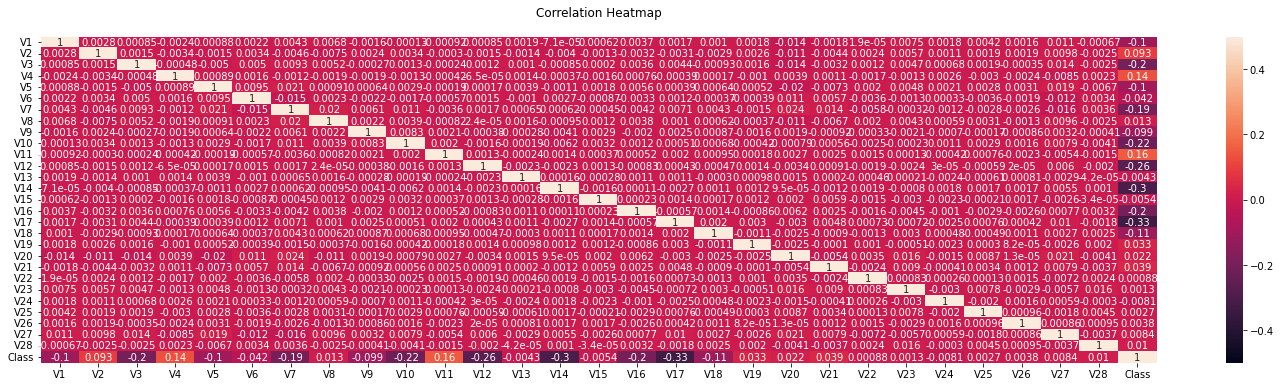

In [230]:
plt.figure(figsize=(25, 6))
heatmap = sns.heatmap(X_t.corr(), vmin=-0.5, vmax=0.5, annot=True) #Got this from (https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e)
heatmap.set_title('Correlation Heatmap', pad=20);

Now we can see which features are more strongly correlated to each other, and to the class. 

From this we can select the ones with the highest values and see how they affect the F1 score. Also, notice how V12, V14 and V17 have the highest correlation with the class which proves what we found in the previous steps. 

**MODEL 1: 2 features**

0.9588920000008493
0.9609872392234435
The best training F1 score= 0.6964769647696477
The best threshold for validation is -35.80000000000021 resulting in F1 score= 0.6993006993006993


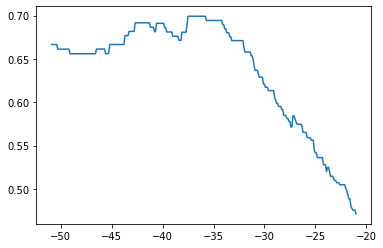

In [231]:
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(non_fraud_X_train[:,[14,17]].reshape(-1,2))
p_gm = gm.score_samples(X_train_array[:,[14,17]].reshape(-1,2))
AUC_1=roc_auc_score(y_train_array, 1-p_gm)
p_gm2 = gm.score_samples(X_val_array[:,[14,17]].reshape(-1,2))
AUC2_1=roc_auc_score(y_val_array, 1-p_gm2)
print (AUC_1)
print (AUC2_1)

maximum1_2,f1score_model1_2=threshold_find(y_val, p_gm2)
f1score_model1_1= f1_score(y_train,p_gm<maximum1_2)
print("The best training F1 score=", f1score_model1_1)
print("The best threshold for validation is", maximum1_2, "resulting in F1 score=", f1score_model1_2)

**MODEL 2: 4 features**

0.9613276319373765
0.9468303457473133
The best training F1 score= 0.7051482059282371
The best threshold for validation is -87.39999999999915 resulting in F1 score= 0.7192982456140351


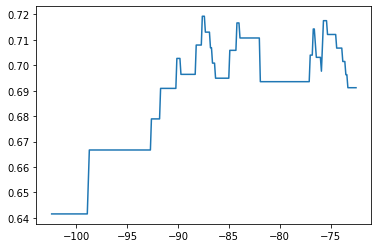

In [232]:
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(non_fraud_X_train[:,[10,12,14,17]].reshape(-1,4))
p_gm = gm.score_samples(X_train_array[:,[10,12,14,17]].reshape(-1,4))
AUC_2=roc_auc_score(y_train_array, 1-p_gm)
p_gm2 = gm.score_samples(X_val_array[:,[10,12,14,17]].reshape(-1,4))
AUC2_2=roc_auc_score(y_val_array, 1-p_gm2)
print (AUC_2)
print (AUC2_2)

maximum2_2,f1score_model2_2=threshold_find(y_val, p_gm2)
f1score_model2_1=f1_score(y_train,p_gm<maximum2_2)
print("The best training F1 score=", f1score_model2_1)
print("The best threshold for validation is", maximum2_2, "resulting in F1 score=", f1score_model2_2)

**MODEL 3: 6 features**

0.9623541408241215
0.9435067539760681
The best training F1 score= 0.6020942408376964
The best threshold for validation is -106.99999999999915 resulting in F1 score= 0.6142857142857143


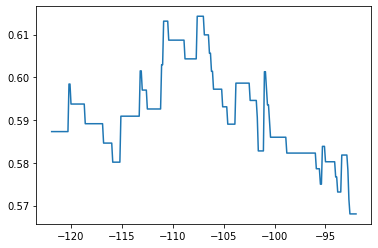

In [233]:
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(non_fraud_X_train[:,[1,7,10,12,14,17]].reshape(-1,6))
p_gm = gm.score_samples(X_train_array[:,[1,7,10,12,14,17]].reshape(-1,6))
AUC_3=roc_auc_score(y_train_array, 1-p_gm)
p_gm2 = gm.score_samples(X_val_array[:,[1,7,10,12,14,17]].reshape(-1,6))
AUC2_3=roc_auc_score(y_val_array, 1-p_gm2)
print (AUC_3)
print (AUC2_3)

maximum3_2,f1score_model3_2=threshold_find(y_val, p_gm2)
f1score_model3_1=f1_score(y_train, p_gm<maximum3_2)
print("The best training F1 score=", f1score_model3_1)
print("The best threshold for validation is", maximum3_2, "resulting in F1 score=", f1score_model3_2)

**MODEL 4: 8 features**

0.9600149586270393
0.9463294999653947
The best training F1 score= 0.6734693877551021
The best threshold for validation is -137.09999999999917 resulting in F1 score= 0.6993006993006993


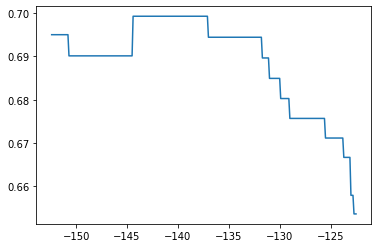

In [234]:
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(non_fraud_X_train[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
p_gm = gm.score_samples(X_train_array[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
AUC_4=roc_auc_score(y_train_array, 1-p_gm)
p_gm2 = gm.score_samples(X_val_array[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
AUC2_4=roc_auc_score(y_val_array, 1-p_gm2)
print (AUC_4)
print (AUC2_4)

maximum4_2,f1score_model4_2=threshold_find(y_val, p_gm2)
f1score_model4_1=f1_score(y_train, p_gm<maximum4_2)
print("The best training F1 score=", f1score_model4_1)
print("The best threshold for validation is", maximum4_2, "resulting in F1 score=", f1score_model4_2)

**MODEL 5: 18 features**

0.9599806477716806
0.9344461337756851
The best training F1 score= 0.5913978494623656
The best threshold for validation is -213.79999999999833 resulting in F1 score= 0.5842696629213482


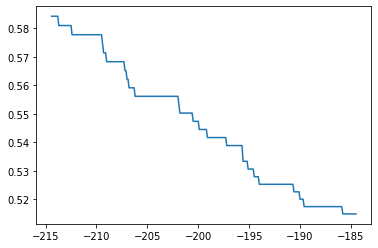

In [235]:
gm = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
gm.fit(non_fraud_X_train[:,1:19].reshape(-1,18))
p_gm = gm.score_samples(X_train_array[:,1:19].reshape(-1,18))
AUC_5=roc_auc_score(y_train_array, 1-p_gm)
p_gm2 = gm.score_samples(X_val_array[:,1:19].reshape(-1,18))
AUC2_5=roc_auc_score(y_val_array, 1-p_gm2)
print (AUC_5)
print (AUC2_5)

maximum5_2,f1score_model5_2=threshold_find(y_val, p_gm2)
f1score_model5_1=f1_score(y_train, p_gm<maximum5_2)
print("The best training F1 score=", f1score_model5_1)
print("The best threshold for validation is", maximum5_2, "resulting in F1 score=", f1score_model5_2)

**MODEL 6: S1<c*S2 with 2 features**

In [236]:
c=np.arange(1,10,0.1)
f1score_model6_1=[]
f1score_model6_2=[]
AUC_6=[]
AUC2_6=[]

a_val=[]
b_val=[]

G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
G1.fit(non_fraud_X_train[:,[14,17]].reshape(-1,2))
S1 = G1.score_samples(X_train_array[:,[14,17]].reshape(-1,2))
S3 = G1.score_samples(X_val_array[:,[14,17]].reshape(-1,2))
G2 = GaussianMixture(n_components = 7, covariance_type = 'full', random_state=0)
G2.fit(fraud_X_train[:,[14,17]].reshape(-1,2))
S2 = G2.score_samples(X_train_array[:,[14,17]].reshape(-1,2))
S4 = G2.score_samples(X_val_array[:,[14,17]].reshape(-1,2))


for j in np.arange(0,10,0.1):
  a_val.append(f1_score(y_val, S3<j*S4))
  b_val.append(roc_auc_score(y_val, S3<j*S4))

a_val=np.array(a_val)
f1score_model6_2=np.max(a_val)
b_val=np.array(b_val)
AUC2_6=np.max(b_val)

best_c2=c[np.argmax(a_val)]

f1score_model6_1=f1_score(y_train, S1<best_c2*S2)
AUC_6=roc_auc_score(y_train, S1<best_c2*S2)

print(f1score_model6_1, f1score_model6_2, AUC_6, AUC2_6)

0.7476038338658146 0.7833333333333334 0.829484504168861 0.9316710165085615


**MODEL 7: S1<c*S2 with 4 features**

In [237]:
f1score_model7_1=[]
f1score_model7_2=[]
AUC_7=[]
AUC2_7=[]

a_val=[]
b_val=[]

G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
G1.fit(non_fraud_X_train[:,[10,12,14,17]].reshape(-1,4))
S1 = G1.score_samples(X_train_array[:,[10,12,14,17]].reshape(-1,4))
S3 = G1.score_samples(X_val_array[:,[10,12,14,17]].reshape(-1,4))
G2 = GaussianMixture(n_components = 5, covariance_type = 'full', random_state=0)
G2.fit(fraud_X_train[:,[10,12,14,17]].reshape(-1,4))
S2 = G2.score_samples(X_train_array[:,[10,12,14,17]].reshape(-1,4))
S4 = G2.score_samples(X_val_array[:,[10,12,14,17]].reshape(-1,4))


for j in np.arange(0,10,0.1):
  a_val.append(f1_score(y_val, S3<j*S4))
  b_val.append(roc_auc_score(y_val, S3<j*S4))

a_val=np.array(a_val)
f1score_model7_2=np.max(a_val)
b_val=np.array(b_val)
AUC2_7=np.max(b_val)

best_c2=c[np.argmax(a_val)]

f1score_model7_1=f1_score(y_train, S1<best_c2*S2)
AUC_7=roc_auc_score(y_train, S1<best_c2*S2)

print(f1score_model7_1, f1score_model7_2, AUC_7, AUC2_7)

0.7937984496124032 0.819672131147541 0.8604779570093758 0.9318077630351999


**MODEL 8: S1<c*S2 with 6 features**

In [238]:
f1score_model8_1=[]
f1score_model8_2=[]
AUC_8=[]
AUC2_8=[]

a_val=[]
b_val=[]

G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
G1.fit(non_fraud_X_train[:,[1,7,10,12,14,17]].reshape(-1,6))
S1 = G1.score_samples(X_train_array[:,[1,7,10,12,14,17]].reshape(-1,6))
S3 = G1.score_samples(X_val_array[:,[1,7,10,12,14,17]].reshape(-1,6))
G2 = GaussianMixture(n_components = 4, covariance_type = 'full', random_state=0)
G2.fit(fraud_X_train[:,[1,7,10,12,14,17]].reshape(-1,6))
S2 = G2.score_samples(X_train_array[:,[1,7,10,12,14,17]].reshape(-1,6))
S4 = G2.score_samples(X_val_array[:,[1,7,10,12,14,17]].reshape(-1,6))


for j in np.arange(0,10,0.1):
  a_val.append(f1_score(y_val, S3<j*S4))
  b_val.append(roc_auc_score(y_val, S3<j*S4))

a_val=np.array(a_val)
f1score_model8_2=np.max(a_val)
b_val=np.array(b_val)
AUC2_8=np.max(b_val)

best_c2=c[np.argmax(a_val)]

f1score_model8_1=f1_score(y_train, S1<best_c2*S2)
AUC_8=roc_auc_score(y_train, S1<best_c2*S2)


print(f1score_model8_1, f1score_model8_2, AUC_8, AUC2_8)

0.7901234567901234 0.832 0.8604704196618186 0.936755382603758


**MODEL 9: S1<c*S2 8 features**

In [239]:
f1score_model9_1=[]
f1score_model9_2=[]
AUC_9=[]
AUC2_9=[]

a_val=[]
b_val=[]

G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
G1.fit(non_fraud_X_train[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
S1 = G1.score_samples(X_train_array[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
S3 = G1.score_samples(X_val_array[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
G2 = GaussianMixture(n_components = 8, covariance_type = 'full', random_state=0)
G2.fit(fraud_X_train[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
S2 = G2.score_samples(X_train_array[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
S4 = G2.score_samples(X_val_array[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))


for j in np.arange(0,10,0.1):
  a_val.append(f1_score(y_val, S3<j*S4))
  b_val.append(roc_auc_score(y_val, S3<j*S4))

a_val=np.array(a_val)
f1score_model9_2=np.max(a_val)
b_val=np.array(b_val)
AUC2_9=np.max(b_val)
best_c2=c[np.argmax(a_val)]

f1score_model9_1=f1_score(y_train, S1<best_c2*S2)
AUC_9=roc_auc_score(y_train, S1<best_c2*S2)

print(f1score_model9_1, f1score_model9_2, AUC_9, AUC2_9)
print(best_c2)

0.8095238095238095 0.8372093023255814 0.8829855313359385 0.9384080620542714
6.300000000000004


**MODEL 10: S1<c*S2 10 features**

In [240]:
f1score_model10_1=[]
f1score_model10_2=[]
AUC_10=[]
AUC2_10=[]

a_val=[]
b_val=[]

G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
G1.fit(non_fraud_X_train[:,1:19].reshape(-1,18))
S1 = G1.score_samples(X_train_array[:,1:19].reshape(-1,18))
S3 = G1.score_samples(X_val_array[:,1:19].reshape(-1,18))
G2 = GaussianMixture(n_components = 9, covariance_type = 'full', random_state=0)
G2.fit(fraud_X_train[:,1:19].reshape(-1,18))
S2 = G2.score_samples(X_train_array[:,1:19].reshape(-1,18))
S4 = G2.score_samples(X_val_array[:,1:19].reshape(-1,18))


for j in np.arange(0,10,0.1):
  a_val.append(f1_score(y_val, S3<j*S4))
  b_val.append(roc_auc_score(y_val, S3<j*S4))

a_val=np.array(a_val)
f1score_model10_2=np.max(a_val)
b_val=np.array(b_val)
AUC2_10=np.max(b_val)
best_c2=c[np.argmax(a_val)]

f1score_model10_1=f1_score(y_train, S1<best_c2*S2)
AUC_10=roc_auc_score(y_train, S1<best_c2*S2)

print(f1score_model10_1, f1score_model10_2, AUC_10, AUC2_10)

0.8193832599118943 0.8372093023255814 0.8928396613671445 0.9336714228410979


I will try doing this method for all the features even though the f1 score did not increase when the number of features included was 8 vs 18.

**MODEL 11 S1<c*S2 with all features**

In [241]:
f1score_model11_1=[]
f1score_model11_2=[]
AUC_11=[]
AUC2_11=[]

a_val=[]
b_val=[]

G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
G1.fit(non_fraud_X_train[:,1:29].reshape(-1,28))
S1 = G1.score_samples(X_train_array[:,1:29].reshape(-1,28))
S3 = G1.score_samples(X_val_array[:,1:29].reshape(-1,28))
G2 = GaussianMixture(n_components = 7, covariance_type = 'full', random_state=0)
G2.fit(fraud_X_train[:,1:29].reshape(-1,28))
S2 = G2.score_samples(X_train_array[:,1:29].reshape(-1,28))
S4 = G2.score_samples(X_val_array[:,1:29].reshape(-1,28))


for j in np.arange(0,10,0.1):
  a_val.append(f1_score(y_val, S3<j*S4))
  b_val.append(roc_auc_score(y_val, S3<j*S4))

a_val=np.array(a_val)
f1score_model11_2=np.max(a_val)
b_val=np.array(b_val)
AUC2_11=np.max(b_val)
best_c2=c[np.argmax(a_val)]

f1score_model11_1=f1_score(y_train, S1<best_c2*S2)
AUC_11=roc_auc_score(y_train, S1<best_c2*S2)

print(f1score_model11_1, f1score_model11_2, AUC_11, AUC2_11)

0.8092485549132947 0.8307692307692308 0.8942229875795127 0.9317139939883623


**PRESENTING THE OUTPUTS:**

In [252]:
AUC_training=[AUC_1,AUC_2,AUC_3,AUC_4,AUC_5,AUC_6,AUC_7,AUC_8,AUC_9,AUC_10,AUC_11]
AUC_validation=[AUC2_1,AUC2_2,AUC2_3,AUC2_4,AUC2_5,AUC2_6,AUC2_7,AUC2_8,AUC2_9,AUC2_10,AUC2_11]
f1scores_training=[f1score_model1_1,f1score_model2_1,f1score_model3_1,f1score_model4_1,f1score_model5_1,f1score_model6_1,f1score_model7_1,f1score_model8_1,f1score_model9_1,f1score_model10_1,f1score_model11_1]
f1scores_validation=[f1score_model1_2,f1score_model2_2,f1score_model3_2,f1score_model4_2,f1score_model5_2,f1score_model6_2,f1score_model7_2,f1score_model8_2,f1score_model9_2,f1score_model10_2,f1score_model11_2]
model=['Model 1', 'Model 2','Model 3','Model 4','Model 5','Model 6','Model 7','Model 8','Model 9','Model 10','Model 11']

append=[AUC_training, AUC_validation, f1scores_training, f1scores_validation]
findings=pd.DataFrame(append,index=['AUC for training', 'AUC for validation','F1 scores for training', 'F1 scores for validation'],columns=model)
pd.set_option('display.max_columns', findings.shape[1]+1)
print(findings)

                           Model 1   Model 2   Model 3   Model 4   Model 5  \
AUC for training          0.958892  0.961328  0.962354  0.960015  0.959981   
AUC for validation        0.960987  0.946830  0.943507  0.946329  0.934446   
F1 scores for training    0.696477  0.705148  0.602094  0.673469  0.591398   
F1 scores for validation  0.699301  0.719298  0.614286  0.699301  0.584270   

                           Model 6   Model 7   Model 8   Model 9  Model 10  \
AUC for training          0.829485  0.860478  0.860470  0.882986  0.892840   
AUC for validation        0.931671  0.931808  0.936755  0.938408  0.933671   
F1 scores for training    0.747604  0.793798  0.790123  0.809524  0.819383   
F1 scores for validation  0.783333  0.819672  0.832000  0.837209  0.837209   

                          Model 11  
AUC for training          0.894223  
AUC for validation        0.931714  
F1 scores for training    0.809249  
F1 scores for validation  0.830769  


Text(446.36136363636354, 0.5, 'F1 Score')

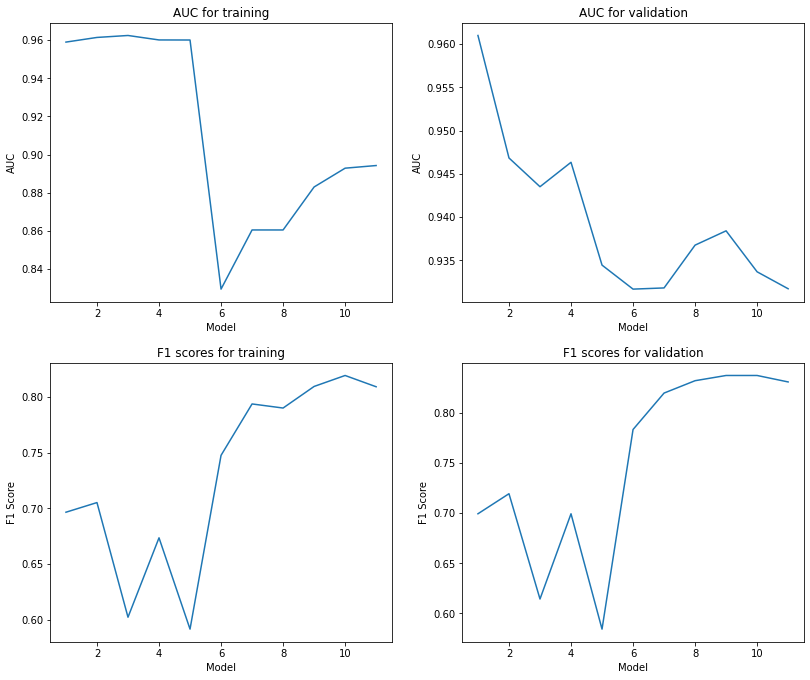

In [244]:
fig, axs = plt.subplots(2, 2,figsize=(12,10))
fig.tight_layout(pad=4.0)

axs[0, 0].plot(np.arange(1,12), AUC_training)
axs[0, 0].set_title('AUC for training')
axs[0, 0].set_xlabel('Model')
axs[0, 0].set_ylabel('AUC')
axs[0, 1].plot(np.arange(1,12), AUC_validation)
axs[0, 1].set_title('AUC for validation')
axs[0, 1].set_xlabel('Model')
axs[0, 1].set_ylabel('AUC')
axs[1, 0].plot(np.arange(1,12), f1scores_training)
axs[1, 0].set_title('F1 scores for training')
axs[1, 0].set_xlabel('Model')
axs[1, 0].set_ylabel('F1 Score')
axs[1, 1].plot(np.arange(1,12), f1scores_validation)
axs[1, 1].set_title('F1 scores for validation')
axs[1, 1].set_xlabel('Model')
axs[1, 1].set_ylabel('F1 Score')

Looking at my results, I can see that all the models had high AUC scores, which is a good indication and the F1 scores for the training and validation data points seem to be behaving in a similar manner in all the models. 

To be able to select the best model, I will consider the F1 score for validation data points. As we can see from the graph, the models that achieve the highest F1 score of 0.83 are both model 9 and model 10. However, I will choose model 9 because there is a chance of overfitting in model 10, as we are taking more features to fit the non-fraudulent data.

## Testing the Best Model on Testing Set

The model that worked better is the 9th model, which consists of having a GMM with one component for the non-fraudulent data and another GMM with 8 components for the fraudulent data and comparing them. The way I chose this model is through evaluating the F1 scores of the validation data.

In [245]:
X_test_array=X_test.copy()
X_test_array=np.array(X_test_array)

In [246]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

G1 = GaussianMixture(n_components = 1, covariance_type = 'full', random_state=0)
G1.fit(non_fraud_X_train[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
S1 = G1.score_samples(X_test_array[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
G2 = GaussianMixture(n_components = 8, covariance_type = 'full', random_state=0)
G2.fit(fraud_X_train[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))
S2 = G2.score_samples(X_test_array[:,[1,3,7,10,12,14,16,17]].reshape(-1,8))

f1_model=f1_score(y_test, S1<6.3*S2)
precision_model=precision_score(y_test,S1<6.3*S2)
recall_model=recall_score(y_test,S1<6.3*S2)

print("The best model achieves an F1 score of", f1_model,"a precision of",precision_model,"and a recall of",recall_model, "for the testing data.")

The best model achieves an F1 score of 0.8 a precision of 0.8169014084507042 and a recall of 0.7837837837837838 for the testing data.


These results are very similar to the results we got the training and validation data, which is an indication that the model is learning properly.

## Note

There are other distributions that could be used to fit our data:
- Gamma distribution: this model is not that popular because it is difficult to deal with, more complicated than the Gaussian (https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/NCSS/Gamma_Distribution_Fitting.pdf). It is specifically useful when we are trying to model any variables that we have in our datasets that seem to be continuous and are always positive with skewed distributions. It could be a case where we have some failure times and other variables within our dataset. In this problem, a Gamma distribution might not be very helpful and hard to manipulate.

- Gumbel distribution: This distribution is of the max/min of a sample normally distributed. It could be helpful for situations where we need to identify which feature is affect the failure of a certain product (weakest link phenomenon). https://www.sciencedirect.com/topics/engineering/gumbel-distribution

Coming from an industrial engineering background, one way we could find suitable distribution to model our data is through fitting them on some software SPC, (or through python fitter https://towardsdatascience.com/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9) and this would give us which distribution fits best our data. However applying them to predict could be more difficult depending on if python had the appropriate functions for them.

Also, here is an interesting article I found that can be used for anomaly detection without assuming any distribution to the model and without requiring to make hand-set thresholds: https://hal.archives-ouvertes.fr/hal-01640325/document and another interesting article about threshold classifiers to maximize F1 scores: https://arxiv.org/pdf/1402.1892.pdf